<a href="https://colab.research.google.com/github/wowthecoder/CNN-fer2013/blob/main/FER2013(Google_Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and Load Data

### 1.1 Installing Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib


---


In [1]:
import tensorflow as tf
import os

In [2]:
#Avoid OOM(Out of Memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Load data from Kaggle

In [3]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install Kaggle

In [4]:
%cd /content/gdrive/MyDrive/ML_Datasets/

/content/gdrive/MyDrive/ML_Datasets


In [5]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/ML_Datasets/" 

In [ ]:
!kaggle datasets download -d msambare/fer2013

---

Now unzip the dataset.

In [ ]:
!unzip fer2013.zip -d facial_emotions

### 1.3 Load Data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

train_ds = tf.keras.utils.image_dataset_from_directory(
    'facial_emotions/train', 
    batch_size=64, 
    image_size=(48, 48), 
    color_mode='grayscale', 
    validation_split=0.2,
    subset="training",
    seed=123,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    'facial_emotions/train', 
    batch_size=64, 
    image_size=(48, 48), 
    color_mode='grayscale', 
    validation_split=0.2,
    subset="validation",
    seed=123,
)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [8]:
train_iterator = train_ds.as_numpy_iterator()
# Get another batch from the iterator
batch = train_iterator.next()

The code below shows that in 1 batch, there are 64 images of size 48x48px, and each image has 1 color channel(grayscale)

In [9]:
# Images represented as numpy arrays
batch[0].shape

(64, 48, 48, 1)

There are 7 classes so the labels are numbered 0-6.

In [10]:
# The image labels
batch[1]

array([5, 0, 5, 4, 0, 5, 0, 4, 3, 2, 2, 5, 4, 0, 3, 2, 1, 3, 2, 3, 4, 3,
       3, 4, 6, 0, 6, 3, 2, 2, 4, 5, 1, 4, 2, 3, 3, 0, 2, 2, 3, 2, 0, 4,
       3, 3, 6, 3, 3, 6, 0, 3, 3, 3, 0, 5, 4, 4, 6, 3, 2, 4, 4, 0],
      dtype=int32)

Check which number is assigned to which label.

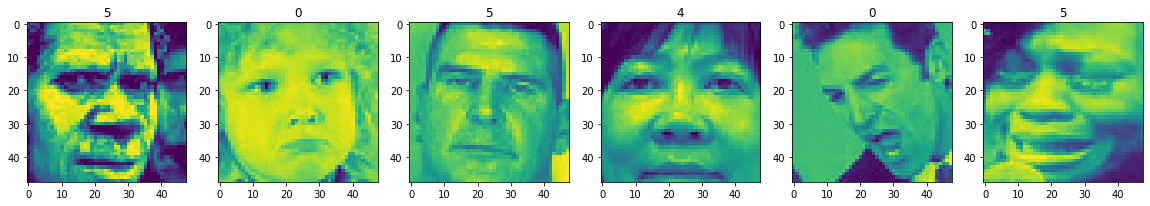

In [13]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.squeeze())
    ax[idx].title.set_text(batch[1][idx])


*   0: angry
*   1: disgust
*   2: fear
*   3: happy
*   4: neutral
*   5: sad
*   6: surprise









# 2. Preprocess Data

### 2.1 Scale Data and One-hot encoding

Scale our data values from 0-255(RGB values) to 0-1   
One-hot encoding is for Categorical entropy

In [11]:
train_ds = train_ds.map(lambda x,y: (x/255, tf.one_hot(y, depth=7)))
val_ds = val_ds.map(lambda x,y: (x/255, tf.one_hot(y, depth=7)))

The code below is for testing.

In [12]:
scaled_iterator = train_ds.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

### 2.2 Optimise Performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE   

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)   
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Deep Learning

### 3.1 Build Deep Learning Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = Sequential([
    # Add padding later
    Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', input_shape=(48,48,1)),
    Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),

    Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),

    Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),

    Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),

    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(0.5),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    # softmax for multi-class classification
    Dense(units=7, activation='softmax'),
])

In [15]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

### 3.2 Train Model

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [18]:
logdir='facial_emotions/logs'

Callback functions:
1.   **ReduceLROnPlateau**
> This function monitors the validation loss for signs of a plateau and then modify the learning rate by the specified factor when a plateau is detected.





In [19]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)

2.   **EarlyStopping**

> The function waits for a number of epochs and terminates the training if no change in the parameter is found.





In [20]:
early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0.001,
    patience=6,
    mode='auto',
    restore_best_weights=True,
)

3.   **ModelCheckpoint**

> Saves the model after every epoch. In case training stops, we can load the checkpoint and resume the progress.









In [21]:
checkpointer = ModelCheckpoint(
    filepath=logdir,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)

In [ ]:
hist = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    shuffle=True,
    callbacks=[lr_reducer, early_stopping, checkpointer],
)

In [ ]:
fig = plt.figure()

plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='acc')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluate Performance

### Test (with test dataset)

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(
    '../input/fer2013/test',
    batch_size=64,
    image_size=(48,48),
    color_mode='grayscale',
)   
test_data = test_data.map(lambda x,y: (x/255, tf.one_hot(y, depth=7)))

In [ ]:
predictions = model.predict(test_data)

In [ ]:
scores = model.evaluate(test_data)
print(model.metrics_names)
print(scores)

Highest accuracy achieved: **62.86%**   
Benchmarks:   
*   human-level accuracy - 65±5%   
*   highest performing published work - 76.82%



